In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
# load vgg16 model for feature extraction
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
# print(model.summary())

In [3]:
file_dir = 'flickr8k'
data_dir = 'data'

In [4]:
features = {}
directory = os.path.join(file_dir, 'Images')
print(f'Directory is : {directory}')

# for img_name in tqdm(os.listdir(directory)):
#     # load images
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert img pixel -> np array
#     image = img_to_array(image)
#     # reshape
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature in dict
#     features[image_id] = feature

Directory is : flickr8k\Images


In [5]:
# features

In [6]:
# store features
# pickle.dump(features, open(os.path.join(data_dir, 'features8k.pkl'), 'wb'))

In [7]:
# load features
with open('data/features8k.pkl', 'rb') as f:
    features = pickle.load(f)

In [8]:
len(features)

8091

In [9]:
df = pd.read_csv(file_dir + '/captions.txt', delimiter=",")
df.dropna()
df = df.astype(str)
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [10]:
# mapping img to cap
mapping = {}

for index, row in df.iterrows(): # iterrows to iter it to one row that has image and caption
    # sperate it to image_id and caption params
    image_id, caption = row['image'].split('.')[0], row['caption'] 
    # split image_id with "."[0] cuz picture name is the same as the number before ".jpg"
#     print(image_id, caption)
    # check if dict has image_id or not 
    if image_id not in mapping: # if not just put it in
        mapping[image_id] = [] 
    # store the caption that matches the image_id
    mapping[image_id].append(caption)

In [11]:
# mapping

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = "<start> " + " ".join([word for word in caption.split() if len(word)>1]) + " <end>"
            captions[i] = caption

In [13]:
clean(mapping)

In [14]:
#check
mapping['1003163366_44323f5815']

['<start> man lays on bench while his dog sits by him <end>',
 '<start> man lays on the bench to which white dog is also tied <end>',
 '<start> man sleeping on bench outside with white and black dog sitting next to him <end>',
 '<start> shirtless man lies on park bench with his dog <end>',
 '<start> man laying on bench holding leash of dog sitting on ground <end>']

In [15]:
# make list of all cap
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
# all_captions

In [17]:
len(all_captions)

40455

In [18]:
# save all_captions
# pickle.dump(all_captions, open(os.path.join('data', 'captions.pkl'), 'wb'))

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

8483

In [21]:
# save tokenizer as model
# pickle.dump(tokenizer, open(os.path.join('data', 'tokenizer.pkl'), 'wb'))

In [22]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
# texts_to_sequences ex.
tokenizer.texts_to_sequences(['<start> shirtless man lies on park bench with his dog <end>'])[0]

[2, 409, 10, 771, 5, 117, 161, 9, 28, 8, 1]

In [25]:
# create data generator to get data in batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys: # data_keys are image_ids of training data
            n += 1 # +1 if get new data
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into in and out pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # padding
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [26]:
# # encoder model
# # image feature layers
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# # sequence feature layers
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)

# # decoder model
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

In [27]:
# model.summary()

In [28]:
# train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size

# for i in range(epochs):
#     # create data generator
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     # fit for one epoch
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [29]:
# save  model
# model.save('data/img_captioning_model.h5')

In [30]:
# load model
loaded_model = load_model('data/img_captioning_model.h5')

In [31]:
# get word from index
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
def predict_caption(model, img, tokenizer, max_length):
    #add tag
    in_text = '<start>'
    #iter over max length
    for i in range(max_length):
        #encode input : turn text into index we tokenized
        seq = tokenizer.texts_to_sequences([in_text])[0]
        #padding
        seq = pad_sequences([seq], max_length)
        #pred next word
        yhat = model.predict([img, seq], verbose=0)
        #get index
        yhat = np.argmax(yhat)
        #convert index to word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        #stop
        if word == 'end':
            in_text += " <end>"
            break
        #append word
        in_text += " " + word
    return in_text

In [33]:
def get_feature(image_path):
    image = load_img(image_path, target_size=(224, 224))
    # convert img pixel -> np array
    image = img_to_array(image)
    # reshape
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0) # this model is vgg16. make sure that ur model is vgg16 before running it
    return feature

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    img_path = 'working/'+ image_name
    print(f'Path is : {img_path}')
    image = Image.open(img_path)
    # ext feature
    t_feature = get_feature(img_path)
#     predict the caption
    y_pred = predict_caption(loaded_model, t_feature, tokenizer, max_length)
    print('Predicted :', y_pred.split('<start> ')[1].split(' <end>')[0])
    plt.imshow(image)

Path is : working/F3f8MD2WQAAwotI.jpg
Predicted : dog runs along the beach


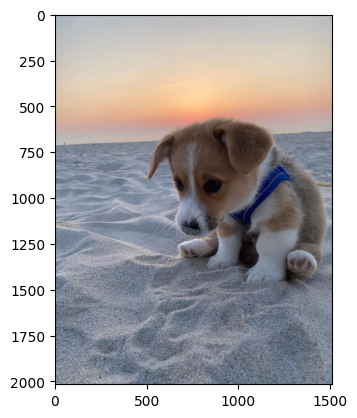

In [35]:
generate_caption('F3f8MD2WQAAwotI.jpg')